####  Setup

In [50]:
import pandas as pd
import os
import math
import json
import matplotlib.pyplot as plt 
import numpy as np
corpus_dir = 'corpus/'

In [3]:
corpus_files = os.listdir(corpus_dir) 
corpus_files = [file for file in corpus_files if file.endswith(".csv")]

### Valid Responses Data

Contabilizamos para cada ejecución la cantidad de respuestas válidas por bloque.

Respuestas válidas != Respuestas correctas. Válidas para el tono: ["A", "S"] y para el número: ["J", "K"].

In [41]:
def is_outlier(file_df):
    percentage = (file_df['rt_1'] > file_df['delay']).mean()
    return percentage >=.8 or (file_df.apply(lambda row: row.rt_2+row.delay, axis=1).mean() > 2000)

In [42]:
if not os.path.exists("metadata.csv"):
    df = pd.DataFrame(columns=["date", "gender", "hand", "age", "response_amount_block_1", "response_amount_block_2", "response_amount_block_3", "response_amount_block_4", "total_response_amount"])
    for file in corpus_files:
        file_df = pd.read_csv(f"{corpus_dir}/{file}")

        file_df = file_df.dropna(subset=['rt_1'])
        file_df = file_df.dropna(subset=['rt_2'])
        if is_outlier(file_df):
            print(f"Outlier for {file}")
            continue
        file = file.split(".")[-2]
        date, gender, hand, age = file.split("_")[1:]
        gender = "woman" if gender == "Mujer" else "man"
        hand = "right" if hand == "Derecha" else "left"
        count_block = lambda block_number : sum(file_df['block'] == block_number)
        b1, b2, b3, b4 = count_block(0), count_block(1), count_block(2), count_block(3)
        df.loc[len(df.index)] = [date, gender, hand, int(age), 
                                    b1, b2, 
                                    b3, b4, 
                                    len(file_df)]
        
    df.to_csv("metadata.csv")
else:
    df = pd.read_csv("metadata.csv")

Outlier for 190.190.193.126_2023-11-01_Mujer_Derecha_26.csv
Outlier for 186.13.97.33_2023-11-01_Mujer_Derecha_43.csv
Outlier for 152.168.59.172_2023-10-27_Hombre_Derecha_23.csv
Outlier for 190.193.233.86_2023-10-25_Hombre_Derecha_32.csv
Outlier for 181.44.118.207_2023-11-02_Mujer_Derecha_23.csv
Outlier for 170.0.86.223_2023-10-25_Mujer_Derecha_33.csv


Text(0.5, 1.0, 'Género')

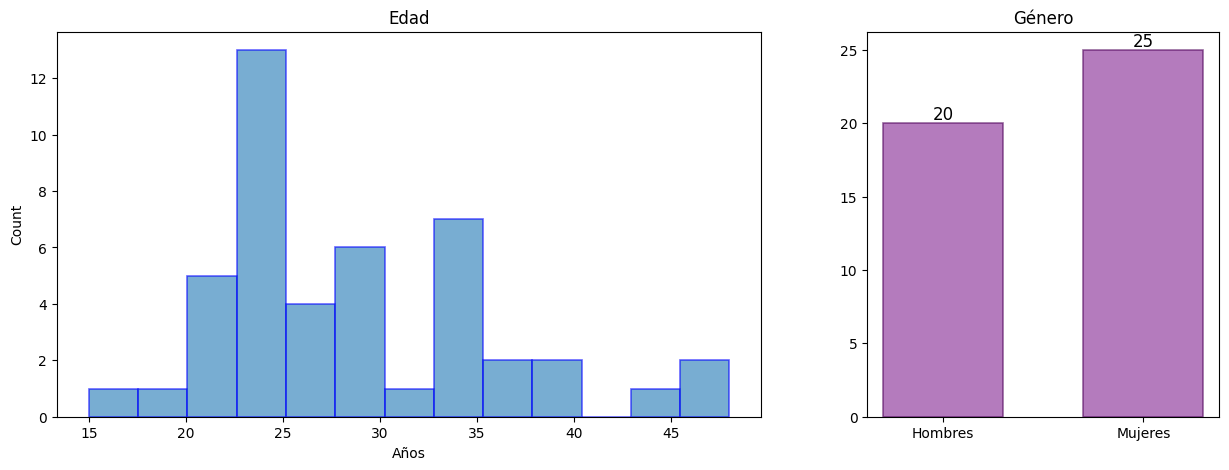

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].hist(df["age"], bins=13, edgecolor="blue", linewidth=1.2, color="#1f77b4", alpha=0.6)
axs[0].set_title("Edad")
axs[0].set_xlabel("Años")
axs[0].set_ylabel("Count")


genders = ["Hombres", "Mujeres"]
counts = df.groupby("gender").count()['age'].values
bars = axs[1].bar(genders, counts, color=["#832491", "#832491"], edgecolor="#51055c", alpha=0.6, linewidth=1.2, width=0.6)

# Adding annotations above each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom', fontsize=12)
axs[1].set_title("Género")


### Figuras del paper

## Figure 2 / Table 2. Effects of the Different Manipulations on the Mean and Dispersion of RT

A. Cambios en el promedio de RT de la tarea de números cuando el delay == 1025 para diferentes manipulaciones experimentales. Cambiar la notación hace al RT mas lento, y dentro de esa condición, las respuestas son mas lentas para distancias cortas que largas. La diferencia ente las condiciones de distancia cercana o lejana es independiente de la manipulación experimental.

B. A different pattern is observed for the interquartile range, which provides a measure of dispersion. While distance manipulation results in a
major change of the interquartile range, there is not a major effect of notation or response complexity.

In [29]:
# get DF (RT_digits_close, RT_digits_far, RT_words_close, RT_words_far) FOR ONLY delay == 1025
indexes = ["name", "RT", "distance", "notation"]

mean_RT_delay_1025 = pd.DataFrame()
name_idx = 0
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df.dropna(subset=['rt_1'])
        file_df = file_df.dropna(subset=['rt_2'])
        percentage = (file_df['rt_1'] > file_df['delay']).mean()
        if percentage >=.8:
            continue
        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        if (file_df['rt_2_accum'].mean() > 2000):
            continue
        file_df["name"] = name_idx
        mean_RT_delay_1025 = pd.concat([
            mean_RT_delay_1025, pd.concat([
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2.mean()).rename(columns={"rt_2": "rt_2_mean"}),
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2_accum.mean()).rename(columns={"rt_2_accum": "rt_2_accum_mean"}),
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2_accum.apply(lambda x: x.quantile(0.75) - x.quantile(0.25))).rename(columns={"rt_2_accum": "interquartile_range"})], 
                axis=1).reset_index().set_index(["notation", "distance", "name"])

            ], axis=0)
        name_idx += 1
#mean_RT_delay_1025["file"] = corpus_files
mean_RT_delay_1025 = mean_RT_delay_1025.reset_index()

In [8]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

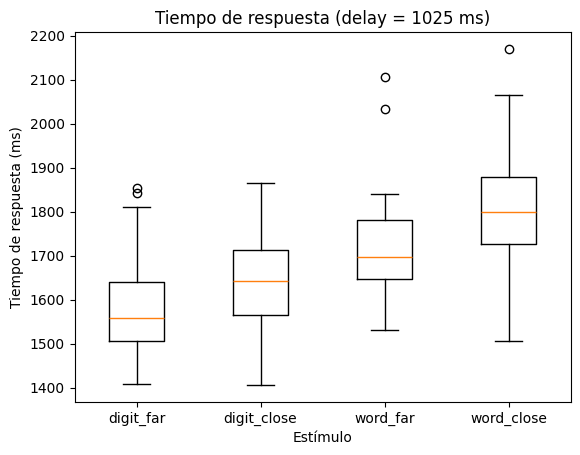

In [12]:
# plot a single figure with 4 bosplots (rt digit_close, rt digit_far, rt word_close, rt word_far)
filter_notation_distance = lambda n, d: mean_RT_delay_1025.loc[(mean_RT_delay_1025["notation"] == n) & (mean_RT_delay_1025["distance"] == d)]["rt_2_accum_mean"].values

digits_far = filter_notation_distance("digit", "far")
digits_close = filter_notation_distance("digit", "close")
words_far = filter_notation_distance("word", "far")
words_close = filter_notation_distance("word", "close")

plt.boxplot([digits_far, digits_close, words_far, words_close], labels=["digit_far", "digit_close", "word_far", "word_close"])
plt.title("Tiempo de respuesta (delay = 1025 ms)")
plt.ylabel("Tiempo de respuesta (ms)")
plt.xlabel("Estímulo")
plt.show()


In [10]:
anova_tableRM = anova_lm(ols("rt_2_mean ~ C(notation) * C(distance, Treatment('far')) + C(name)", mean_RT_delay_1025).fit(), typ=2)
anova_tableRM

,sum_sq,df,F,PR(>F)
C(notation),1.103837e+06,1.0,188.085672,5.809158e-27
"C(distance, Treatment('far'))",2.619368e+05,1.0,44.632083,6.435572e-10
C(name),1.492607e+06,43.0,5.914630,2.043139e-15
"C(notation):C(distance, Treatment('far'))",9.998380e+03,1.0,1.703650,1.941346e-01
Residual,7.570752e+05,129.0,NaN,NaN


In [11]:
anova_tableRM2 = anova_lm(ols("interquartile_range ~ C(notation) * C(distance, Treatment('far')) + C(name)", mean_RT_delay_1025).fit(), typ=2)
anova_tableRM2

,sum_sq,df,F,PR(>F)
C(notation),90092.750000,1.0,12.832549,0.000481
"C(distance, Treatment('far'))",118872.022727,1.0,16.931785,0.000069
C(name),699545.338068,43.0,2.317237,0.000153
"C(notation):C(distance, Treatment('far'))",196.568182,1.0,0.027999,0.867374
Residual,905663.002841,129.0,NaN,NaN


In [ ]:
results = pd.DataFrame(columns=["Task Manipulation", "Effect", "Mean", "Interquartile Range"])
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect", 
                                    f"F={anova_table1.loc['C(notation)', 'F']}, p={anova_table1.loc['C(notation)', 'PR(>F)']}", 
                                    f"F={anova_table3.loc['C(notation)', 'F']}, p={anova_table3.loc['C(notation)', 'PR(>F)']}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect of distance", 
                                    f"F={anova_table1.loc['distance', 'F']}, p={anova_table1.loc['distance', 'PR(>F)']}",
                                    f"F={anova_table3.loc['distance', 'F']}, p={anova_table3.loc['distance', 'PR(>F)']}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Interaction", 
                                    f"F={anova_table2.loc['notation_distance', 'F']}, p={anova_table2.loc['notation_distance', 'PR(>F)']}",
                                    f"F={anova_table4.loc['notation_distance', 'F']}, p={anova_table4.loc['notation_distance', 'PR(>F)']}"]

results


,Task Manipulation,Effect,Mean,Interquartile Range
0,Effect of notation,Main effect,"F=47.00333436162546, p=8.52068318685329e-11","F=3.3301429274855314, p=0.06950538504052996"
1,Effect of notation,Main effect of distance,"F=10.325149942741593, p=0.0015286244684478442","F=7.631875253289698, p=0.006266589768766271"
2,Effect of notation,Interaction,"F=19.268956605720945, p=5.131318083601494e-11","F=3.883269244311608, p=0.009970523393495504"


In [30]:
# substract 1025 to mean_RT_delay_1025["rt_2_accum_mean"]
mean_RT_delay_1025["rt_2_accum_mean"] = mean_RT_delay_1025["rt_2_accum_mean"] - 1025

/Users/aoppenheim/Desktop/neuro/tps/INCC-parsing_a_cognitive_task/.venv/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x108221430> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()
/Users/aoppenheim/Desktop/neuro/tps/INCC-parsing_a_cognitive_task/.venv/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x108221430> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


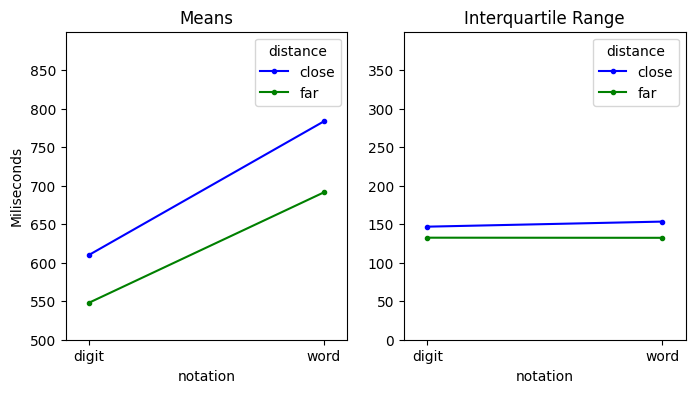

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].set_ylim([500, 900])
ax[0].set_yticks(range(500, 900, 50))

ax[1].set_ylim([0, 400])
ax[1].set_yticks(range(0, 400, 50))

ax[0].set_xticks(range(2))
ax[0].set_xticklabels(['Digits', 'Words'])
ax[1].set_xticks(range(2))
ax[1].set_xticklabels(['Digits', 'Words'])

ax[0].set_title('Means')
ax[1].set_title('Interquartile Range')



# interaction plot for mean
interaction_plot(mean_RT_delay_1025["notation"], mean_RT_delay_1025["distance"], mean_RT_delay_1025["rt_2_accum_mean"], ax=ax[0], colors=['blue', 'green'])

# interaction plot for interquartile range
# calculate interquartile range for each group
interquartile_range = mean_RT_delay_1025.groupby(["notation", "distance"]).rt_2_accum_mean.apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).to_frame()
interquartile_range = interquartile_range.reset_index()
interquartile_range.columns = ["notation", "distance", "interquartile_range"]
interaction_plot(interquartile_range["notation"], interquartile_range["distance"], interquartile_range["interquartile_range"], ax=ax[1], colors=['blue', 'green'])


ax[0].set_ylabel('Miliseconds')
ax[1].set_ylabel('')



plt.show()


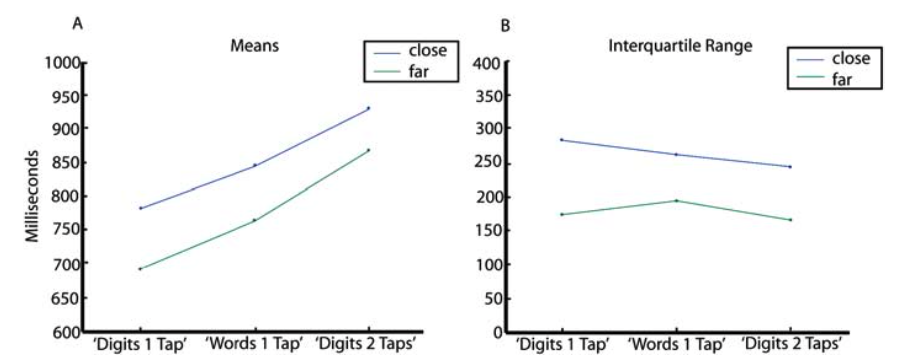

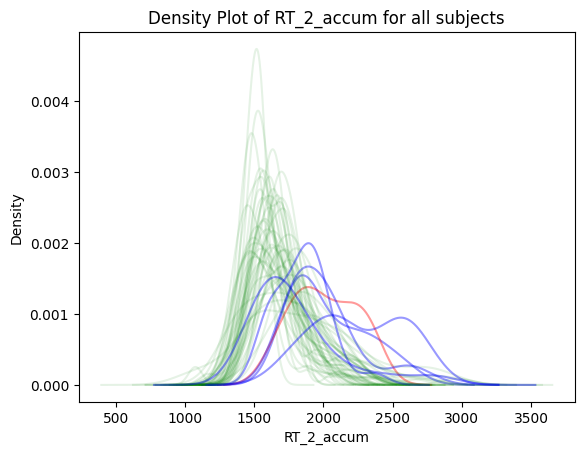

In [23]:
# plotear hist acumulado de todos los sujetos y ver que onda el ruido
from matplotlib import pyplot

#bins = numpy.linspace(-10, 10, 100)
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df[file_df["delay"] == 1025]
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        # # Find the cases where rt_2_accum is larger than 2000 ms half of the time
        percentage = (file_df['rt_1'] > file_df['delay']).mean()
        if percentage >=.8:
            file_df.rt_2_accum.plot.density(color='b',alpha=0.4)
            continue

        if (file_df['rt_2_accum'].mean() > 2000):
            file_df.rt_2_accum.plot.density(color='r',alpha=0.4)
        else:
            file_df.rt_2_accum.plot.density(color='green',alpha=0.1)

plt.title("Density Plot of RT_2_accum for all subjects")
plt.xlabel("RT_2_accum")
pyplot.show()

In [36]:
mean_notation_RTs = pd.DataFrame()
mean_distance_RTs = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        # notation
        rt1_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_1.mean())
        # rt2 in reality is delay + rt2
        rt2_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_2_accum.mean())
        mean_notation_RTs = pd.concat([mean_notation_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)
        # distance
        rt1_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_1.mean())
        rt2_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_2_accum.mean())
        mean_distance_RTs = pd.concat([mean_distance_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)

mean_notation_RTs = mean_notation_RTs.reset_index()
mean_distance_RTs = mean_distance_RTs.reset_index()

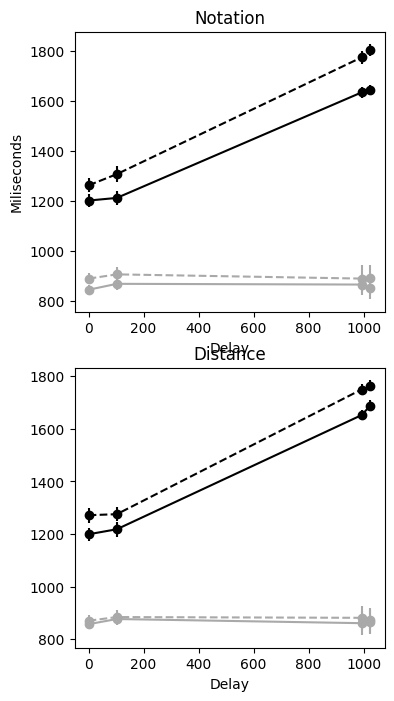

In [39]:
# show a figure with two subplots
# subplot 1: Scatter plot with mean RTs for each delay (x axis) and notation (color) 
# subplot 2: Scatter plot with mean RTs for each delay (x axis) and distance (color)

fig, ax = plt.subplots(2, 1, figsize=(4, 8))

# add scatter plot with lines for mean_notation_RTs with notation as color and line properties
for notation in ["digit", "word"]:
    rt_1_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean().reset_index()
    rt_1_standard_error = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    rt_2_accum_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.mean().reset_index()
    rt_2_accum_standard_error = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    # scatter with error bars
    fmt_line = 'o-' if notation == "digit" else 'o--'
    
    ax[0].errorbar( rt_1_mean[rt_1_mean["notation"] == notation]["delay"], 
                    rt_1_mean[rt_1_mean["notation"] == notation]["rt_1"], 
                    yerr=rt_1_standard_error[rt_1_standard_error["notation"] == notation]["rt_1"], 
                    fmt=fmt_line, label=notation, color="darkgray")

    ax[0].errorbar( rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["rt_2_accum"], 
                    yerr=rt_2_accum_standard_error[rt_2_accum_standard_error["notation"] == notation]["rt_2_accum"], 
                    fmt=fmt_line, label=notation, color="black")

for distance in ["close", "far"]:
    rt_1_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.mean().reset_index()
    rt_1_standard_error = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()


    rt_2_accum_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.mean().reset_index()
    rt_2_accum_standard_error = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    # scatter with error bars
    fmt_line = 'o-' if distance == "far" else 'o--'
    
    ax[1].errorbar( rt_1_mean[rt_1_mean["distance"] == distance]["delay"], 
                    rt_1_mean[rt_1_mean["distance"] == distance]["rt_1"], 
                    yerr=rt_1_standard_error[rt_1_standard_error["distance"] == distance]["rt_1"], 
                    fmt=fmt_line, label=distance, color="darkgray")

    ax[1].errorbar( rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["rt_2_accum"], 
                    yerr=rt_2_accum_standard_error[rt_2_accum_standard_error["distance"] == distance]["rt_2_accum"], 
                    fmt=fmt_line, label=distance, color="black")
    

ax[0].set_title('Notation')
ax[0].set_ylabel('Miliseconds')
ax[0].set_xlabel('Delay')

ax[1].set_title('Distance')
ax[1].set_ylabel('')
ax[1].set_xlabel('Delay')

plt.show()

# Cambiar std por error estandar /sqrt(n)




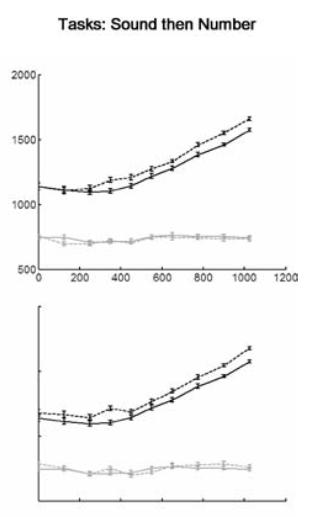

##  Figure 5

Thus, our purpose was to test the prediction of our model that the notation and response-complexity manipulations should affect the parameter $t_0$ while the distance manipulation should affect the parameter $\alpha$.

$$g(t) = \frac{1}{\sigma \cdot \sqrt{2\pi \cdot (t-t_0)^3}} \cdot \exp(-\frac{(1-\alpha\cdot (t-t_0))^2}{2\cdot \sigma^2(t-t_0)})$$

In [51]:
# for each subject, 
# keep delay == 1025
# separate (digit,far), (digit,close), (word,far), (word,close)
# and fit \alpha, t_0 (sigma=0.018), save it on a df
RTs_1025 = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        if is_outlier(file_df):
            continue
        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df = file_df[file_df["rt_2"].notna()]
        file_df["name"] = file.split(".")[-2]
        RTs_1025 = pd.concat([RTs_1025, file_df], axis=0)

In [199]:
hist, bins = np.histogram(list(RTs_1025.groupby(["notation", "distance"]).rt_2)[0][1].values, bins=200)
hist_bins = list(zip(hist, bins))
hist_bins = [hb for hb in hist_bins if hb[0] != 0 and 240 < hb[1]]
hist, bins = zip(*hist_bins)
hist, bins = list(hist), list(bins)
hist = hist / sum(hist) # transform to probability
width = 0.7 * (bins[1] - bins[0])
hist = hist[:-1]


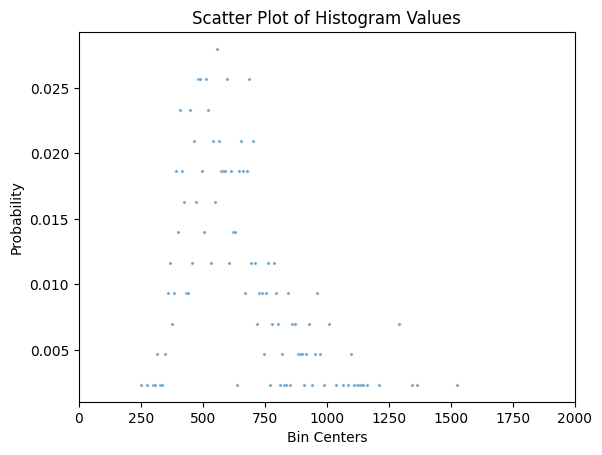

In [200]:
center = (np.array(bins[:-1]) + np.array(bins[1:])) / 2

# Create a scatter plot
plt.scatter(center, hist, s=width, alpha=0.7, edgecolors="w", linewidth=0.5)
# set lim from 0
plt.xlim(0, 2000)


# Set labels and title
plt.xlabel("Bin Centers")
plt.ylabel("Probability")
plt.title("Scatter Plot of Histogram Values")

# Show the plot
plt.show()

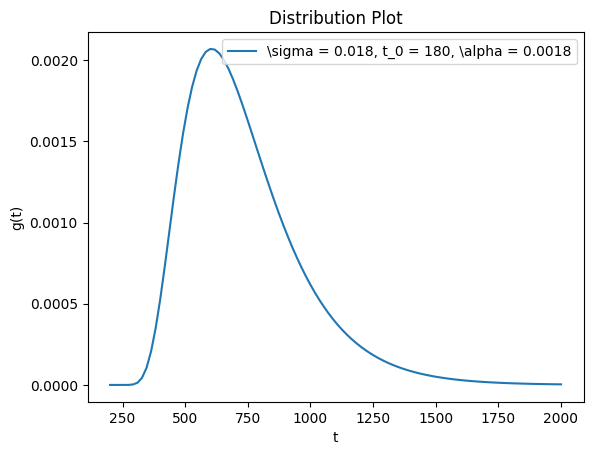

In [195]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def g(t, sigma, t0, alpha):
    numerator = 1 / (sigma * np.sqrt(2 * np.pi * (t - t0)**3))
    exponent = -((1 - alpha * (t - t0))**2) / (2 * sigma**2 * (t - t0))
    result = numerator * np.exp(exponent)
    return result

# Generate data points for plotting
t_values = np.linspace(200, 2000, 100)


sigma_value2, t0_value2, alpha_value2 = .018, 180, .0018
g_values2 = g(t_values, sigma_value2, t0_value2, alpha_value2)


# Plot the distribution
# plt.plot(t_values, g_values, label=r'\sigma = {0}, t_0 = {1}, \alpha = {2}'.format(sigma_value, t0_value, alpha_value))
plt.plot(t_values, g_values2, label=r'\sigma = {0}, t_0 = {1}, \alpha = {2}'.format(sigma_value2, t0_value2, alpha_value2))
plt.xlabel('t')
plt.ylabel('g(t)')
plt.title('Distribution Plot')
plt.legend()
plt.show()


In [260]:
import numpy as np
from scipy.optimize import curve_fit
import math

def g(t, alpha, t0):
    sigma = .018
    numerator = 1 / (sigma * np.sqrt(2 * np.pi * (t - t0)**3))
    exponent = -((1 - alpha * (t - t0))**2) / (2 * sigma**2 * (t - t0))
    result = numerator * np.exp(exponent)
    return result

# Curve fitting
popt, pcov = curve_fit(g, list(center), list(hist), bounds=([0, min(center)-100], [.001, min(center)]))
alpha_opt, t0_opt = popt

print(f"Optimal alpha: {alpha_opt}, Optimal t0: {t0_opt}")


Optimal alpha: 0.0009999999997165675, Optimal t0: 151.51250000514244


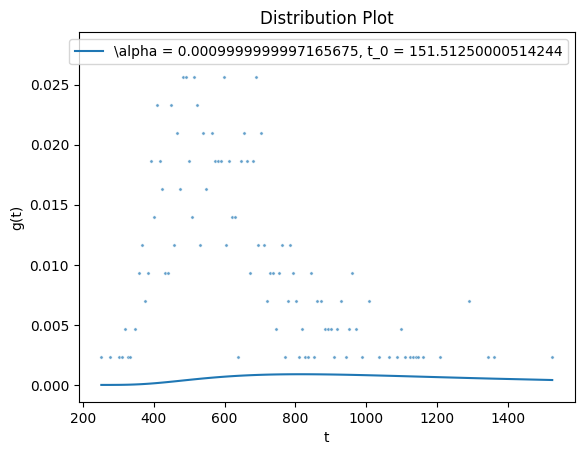

In [261]:
# plot the fitted curve
# t_values = np.linspace(200, 2000, 100)
g_values = g(list(center), 0.0009, t0_opt)
# plt.plot(list(center), g_values, label=r'\alpha = {0}, t_0 = {1}'.format(alpha_opt, t0_opt)) over the scatter plot
plt.scatter(center, hist, s=width, alpha=0.7, edgecolors="w", linewidth=0.5)
plt.plot(list(center), g_values, label=r'\alpha = {0}, t_0 = {1}'.format(alpha_opt, t0_opt))
plt.xlabel('t')
plt.ylabel('g(t)')
plt.title('Distribution Plot')
plt.legend()
plt.show()

In [30]:
def g(t, alpha, t0):
    denominador = 0.018*math.sqrt(2*math.pi * (t-t0)**3)
    numerador_expo = (1-alpha*(t-t0)**2)
    denominador_expo = (2*0.018**2*(t-t0))
    return 1/(denominador) * math.exp(- (numerador_expo/denominador_expo))

In [28]:
for f in file_df.groupby(["notation", "distance"]).rt_2:
    print(f[1].values)

[558. 650. 679. 587. 475. 645. 474. 569.]
[423. 499. 438. 490. 459. 440. 451. 407. 385. 504. 338. 356.]
[505. 509. 569. 858. 539. 488. 580. 727. 564.]
[524. 614. 620. 545. 512. 438. 655. 471. 443. 570. 524.]


In [23]:
# Segun Juan la figura 6 corresponde solamente a un sujeto. Tomar solo uno, si vemos que tenemos pocos datos veamos que pasa usando todos los sijeto (no debería funcionar ya que hay mucho ruido/varianza)
subject = 4
subject_file = corpus_files[subject]
assert subject_file.endswith(".csv")

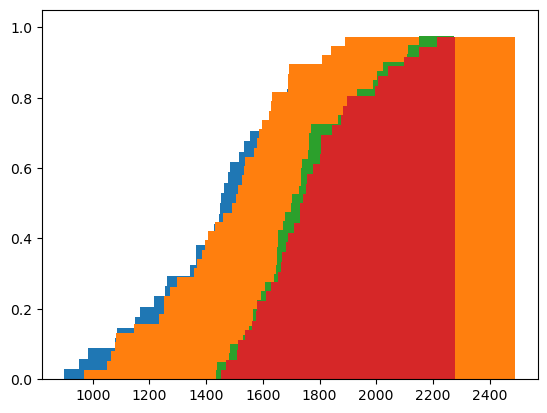

In [24]:
file_df = pd.read_csv(f"{corpus_dir}/{subject_file}")
file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
delays = [0, 102.5, 992.5, 1025.0]
delays_attr = {d:plt.hist(file_df[file_df["delay"] == d]["rt_2_accum"] , bins=1000, density=True, cumulative=True) for d in delays} # n, bins, patches
delays_attr_scatter = {d: ([0.5 * (bins[i] + bins[i+1]) for i in range(len(n))], n) for d, (n, bins, patches) in delays_attr.items()}

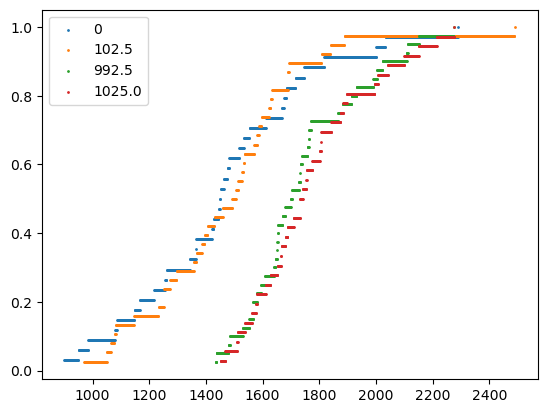

In [25]:
for d, (bins_mean, n) in delays_attr_scatter.items():
    plt.scatter(bins_mean, n, label = d, s=1)

plt.legend()

t_0, \alpha, \sigma, T 

Parameters of the mathematical model used to fit the distributions of RTs to the first task. The model we use is a simple variant of a general class of models known as random-walk models. Briefly, the model supposes a fixed delay (t_0) followed by a stochastic ac- cumulation of evidence with a fixed drift rate (\alpha) and added Gaussian noise (whose amplitude is determined by the "diffusion constant" \sigma), which stops once it hits a threshold level (T).

In [88]:
from scipy.stats import invgauss

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html